# Quick start guide to QSPRpred

Welcome to the quick start guide to QSPRpred.
Here we will cover the fundamentals of using QSPRpred.
We will show you how to create a dataset, train a QSAR model, and make predictions.

While this tutorial provides a good starting point, there are many additional features that are not covered here.
For more in-depth information, you can explore [the other tutorials](table_of_contents.md) and consult the [documentation](https://cddleiden.github.io/QSPRpred/docs/).


## Creating a dataset
In this tutorial, we will work with a dataset containing bioactivity information for various compounds tested on the human adenosine A2A receptor. The data was collected from [Papyrus](https://github.com/OlivierBeq/Papyrus-scripts), a curated bioactivity database. The dataset is available in the `tutorial_data` folder (to recreate the dataset yourself run `tutorial_data/create_tutorial_data.py`)

To start we will load the tsv file containing the dataset.

In [15]:
import pandas as pd

df = pd.read_csv('tutorial_data/A2A_LIGANDS.tsv', sep='\t')

df.head()

,SMILES,pchembl_value_Mean
0,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,8.68
1,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,4.82
2,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,5.45
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20


Now we will create a `QSPRDataset` object from the data. 
This object contains the data and metadata for the dataset, and can be used to train a QSAR model.

In [16]:
import os
from qsprpred.data.data import QSPRDataset

os.makedirs("tutorial_output/data", exist_ok=True)

dataset = QSPRDataset(
  	df=df, 
  	store_dir="tutorial_output/data",
  	name="A2A_LIGANDS",
  	target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
  	random_state=42
)

dataset.getDF()

,SMILES,pchembl_value_Mean,QSPRID
QSPRID,,,
A2A_LIGANDS_0,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,8.68,A2A_LIGANDS_0
A2A_LIGANDS_1,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,4.82,A2A_LIGANDS_1
A2A_LIGANDS_2,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,A2A_LIGANDS_2
A2A_LIGANDS_3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,5.45,A2A_LIGANDS_3
A2A_LIGANDS_4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,A2A_LIGANDS_4
...,...,...,...
A2A_LIGANDS_4077,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,7.09,A2A_LIGANDS_4077
A2A_LIGANDS_4078,Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1,8.22,A2A_LIGANDS_4078
A2A_LIGANDS_4079,Nc1nc(Nc2ccc(F)cc2)nc(CSc2nnc(N)s2)n1,4.89,A2A_LIGANDS_4079


After creating the dataset, we need to prepare it for model training.
To do this we need to specifiy what molecule descriptors to calculate as features for the model.
Here we will calculate Morgan fingerprints.
We will also specify what split to use to split the data into training and test sets.
In this example we will use a random split with 80% of the data for training and 20% for testing.

In [17]:
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from qsprpred.data.utils.datasplitters import RandomSplit

# define the feature calculator to calculate Morgan fingerprints
feature_calculator = MoleculeDescriptorsCalculator(
    desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)]
)

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

dataset.save()

Missing values filled with nan


Number of samples train set: 3265
Number of samples test set: 817


## Training a model

Having successfully created a dataset, we can now train a QSAR model.
Here we will train a model using the `KNeighborsRegressor` estimator from scikit-learn.

To do this we first need to create a `QSPRModel` object, which contains the estimator and metadata for the model.
We will use the `SklearnModel` subclass, which is a wrapper for scikit-learn models.

In this example: the training of our model is divided into three steps:
* cross-validation: estimate the performance of the model on the training set
* test set evaluation: estimate the performance of the model on the test set
* full training: train the model on the full dataset, to be used for making predictions

In [18]:
from qsprpred.models.sklearn import SklearnModel
from qsprpred.models.metrics import SklearnMetric
from sklearn.neighbors import KNeighborsRegressor
from qsprpred.models.assessment_methods import CrossValAssessor, TestSetAssessor

os.makedirs("tutorial_output/models", exist_ok=True)

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model = SklearnModel(
    base_dir = 'tutorial_output/models',
    data = dataset,
    alg = KNeighborsRegressor,
    name = 'KNN_REG'
)

# We define the metric to be used for model assessment from the SklearnMetric class
score_func = SklearnMetric.getDefaultMetric(model.task)

# We can now assess the model performance on the training set using cross validation
CrossValAssessor(score_func)(model)

# and on the test set
TestSetAssessor(score_func)(model)

# Finally, we need to fit the model on the complete dataset if we want to use it further
model.fitAttached()

# and save the model
model.save()

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

'tutorial_output/models/KNN_REG/KNN_REG_meta.json'

The results can be easily visualized using the `CorrelationPlot` class

  ModelName        R2      RMSE  Set
0   KNN_REG  0.620648  0.713739   cv
1   KNN_REG  0.621529  0.722205  ind


/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

<Axes: title={'center': 'KNN_REG (KNeighborsRegressor)'}, xlabel='Experimental pchembl_value_Mean', ylabel='Predicted pchembl_value_Mean'>

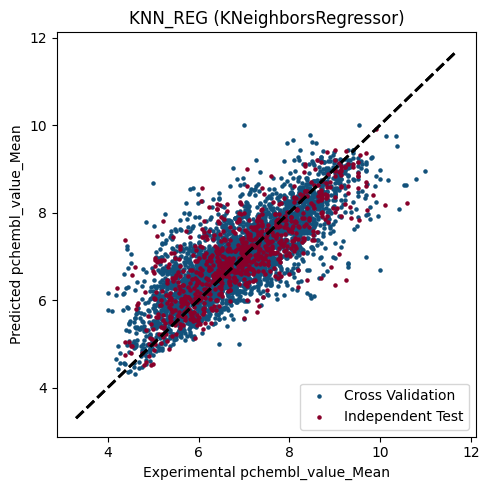

In [19]:
from qsprpred.plotting.regression import CorrelationPlot

plt = CorrelationPlot([model])
axes, summary = plt.make(save=False, property_name='pchembl_value_Mean')
print(summary)
axes[0]

## Making predictions

After training the model, we can use it to make predictions on new compounds.

In [20]:
smiles_list = ["c1(cc(c(O)cc1)O)CCN", "CC(=O)OC1=CC=CC=C1C(=O)O", "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]

model.predictMols(smiles_list)

Missing values filled with nan


array([[6.572],
       [5.202],
       [6.424]])

## Reloading

The `QSPRDataset` and `QSPRModel` objects can be easily reloaded from disk using the `fromFile` methods.

In [1]:
dataset = QSPRDataset.fromFile('./tutorial_output/data/A2A_LIGANDS_df.pkl')
model = QSPRModel.fromFile('./tutorial_output/models/KNN_REG/KNN_REG_meta.json')

## What's next?

This tutorial has covered the basics of using QSPRpred. If you are new to QSPRpred and interested in learning more, we recommend you check out the regression or classification tutorial next.
If you are looking for a specific topic, you can have a look in the [list of tutorials](table_of_contents.md).